In [40]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import sys
sys.path.append("../../")
from src.soporte_metricas import (
    obtener_metricas,
    comparar_arboles,
    residual_plot,
    generar_df_comparador
)
pd.options.display.float_format = "{:,.2f}".format
# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [41]:
df = pd.read_csv("../../datos/06_rent_outliers_gestionados.csv")

# Decision Tree
- El árbol de decisiones se usa para modelos no lineales
- Vamos a probarlo a ver si mejora nuestras métricas

In [42]:
X = df.drop(columns="price")
y = df[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, # Todo menos la Variable Respuesta
                                                    y, # La variable Respuesta
                                                    train_size=0.7, # Como dividir los datos en este caso 80% train, 20% test
                                                    random_state=42, # Semilla, para que lo haga igual para cualquier persona
                                                    shuffle=True 
                                                    )

### Decision tree sin ajustar

In [43]:
modelo_arbol = DecisionTreeRegressor()
modelo_arbol.fit(X_train,y_train)
y_pred_test = modelo_arbol.predict(X_test)
y_pred_train = modelo_arbol.predict(X_train)
df_metricas = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas

,r2_score,MAE,MSE,RMSE
train,1.00,0.00,0.00,0.00
test,0.49,40.08,"3,740.59",61.16


In [44]:
importancia = pd.DataFrame(modelo_arbol.feature_importances_,columns=["Importancia"], index= X.columns).sort_values(by="Importancia",ascending=False)
importancia

,Importancia
municipality,0.78
district,0.06
size,0.05
rooms_2 habitaciones,0.02
hasLift_tiene ascensor,0.02
rooms_1 habitacion,0.01
distancia_centro,0.01
floor_cuarto,0.01
floor_desconocido,0.01
floor_segundo,0.01


<Axes: ylabel='None'>

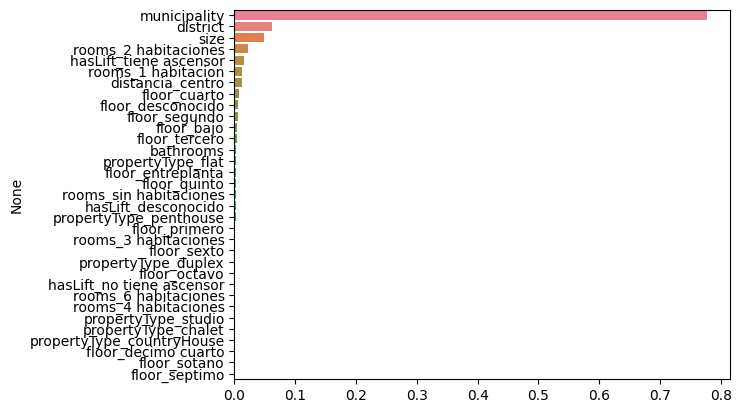

In [45]:
sns.barplot(y=importancia.index,x=importancia["Importancia"].values,hue=importancia.index)

# Mejor modelo 
- Este es el modelo más Aceptable
- Vamos a tocar los parámetros para reducir el overfitting

In [46]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [5, 10, 15, 20],
    'max_leaf_nodes': [10 , 20, 30, 40],
    'min_samples_leaf': [5, 10, 15, 20],
    'min_samples_split': [20, 30, 40, 50]
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol = grid_search_arbol.best_estimator_

In [47]:
modelo_final_arbol.fit(X_train,y_train)
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)
df_metricas = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas

,r2_score,MAE,MSE,RMSE
train,0.78,24.88,"1,288.29",35.89
test,0.63,36.53,"2,739.76",52.34


In [48]:
modelo_final_arbol

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=10, min_samples_leaf=10,
                      min_samples_split=20)

### Resultados
- max_depth = 5
- max_leaf = 10
- min_samples_leaf = 10
- min_samples_split = 20

### Nuevo test
- max_depth = 1,2,3,4,5
- max_leaf = 5,6,7,8,9,10
- min_samples_leaf = 5,6,7,8,9,10,11,12,13,14,15
- min_samples_split = 5,10,15,20,25

# Tree 2

In [49]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [1,2,3,4,5],
    'max_leaf_nodes': [5,6,7,8,9,10],
    'min_samples_leaf': [5,6,7,8,9,10,11,12,13,14,15],
    'min_samples_split': [5,10,15,20,25]
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol2 = grid_search_arbol.best_estimator_

In [50]:
modelo_final_arbol2.fit(X_train,y_train)
y_pred_test = modelo_final_arbol2.predict(X_test)
y_pred_train = modelo_final_arbol2.predict(X_train)
df_metricas = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas

,r2_score,MAE,MSE,RMSE
train,0.78,24.20,"1,301.22",36.07
test,0.65,34.79,"2,542.88",50.43


In [51]:
modelo_final_arbol2

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=7, min_samples_leaf=7,
                      min_samples_split=10)

# Tree 3

### Resultados
- max_depth = 4
- max_leaf = 7
- min_samples_leaf = 7
- min_samples_split = 5

### Nuevo test
- max_depth = 1,2,3,4,5
- max_leaf = 5,6,7,8,9,10
- min_samples_leaf = 6,7,8,9
- min_samples_split = 1,2,3,4,5,6,7,8,9,10

In [52]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [2,3,4,5,6],
    'max_leaf_nodes': [5,6,7,8,9,10],
    'min_samples_leaf': [6,7,8,9],
    'min_samples_split': [1,2,3,4,5,6,7,8,9,10]
}

grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, # Cross Validation de 5 grupos solo
                                 scoring="neg_mean_squared_error",
                                 n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)
modelo_final_arbol3 = grid_search_arbol.best_estimator_

In [53]:
modelo_final_arbol3.fit(X_train,y_train)
y_pred_test = modelo_final_arbol3.predict(X_test)
y_pred_train = modelo_final_arbol3.predict(X_train)
df_metricas = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricas

,r2_score,MAE,MSE,RMSE
train,0.78,24.20,"1,301.22",36.07
test,0.65,34.79,"2,542.88",50.43


In [54]:
modelo_final_arbol3

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=7, min_samples_leaf=7,
                      min_samples_split=8)

# Mejores resultados
- max_depth: 4
- max_leaf_nodes: 7
- min_samples_leaf: 7
- min_samples_split: 8


# ¿Porque es el mejor?
- Menor diferencia entre train y test
- R2 alto
- Entre todos los modelos es lo mejor que he podido conseguir

# Probemos el modelo final

In [56]:
modelo_arbol = modelo_final_arbol3
modelo_final_arbol.fit(X_train,y_train)
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)
df_metricasvfinal = obtener_metricas(y_train,y_pred_train,y_test,y_pred_test)
df_metricasvfinal

,r2_score,MAE,MSE,RMSE
train,0.78,24.88,"1,288.29",35.89
test,0.63,36.53,"2,739.76",52.34


In [57]:
importancia = pd.DataFrame(modelo_final_arbol.feature_importances_,columns=["Importancia"], index= X.columns).sort_values(by="Importancia",ascending=False)
importancia

,Importancia
municipality,0.94
district,0.03
size,0.02
hasLift_no tiene ascensor,0.01
bathrooms,0.00
propertyType_chalet,0.00
propertyType_countryHouse,0.00
propertyType_duplex,0.00
distancia_centro,0.00
propertyType_penthouse,0.00


<Axes: ylabel='None'>

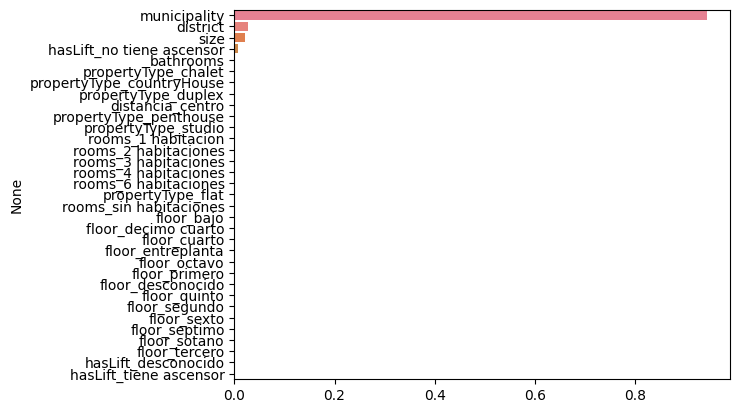

In [58]:
sns.barplot(y=importancia.index,x=importancia["Importancia"].values,hue=importancia.index)

### En nuesto modelo:
- municipality: es la que más influye
- district: le sigue
- size: importa mucho en el precio
- tiene ascensor: también afecta


# Visualicemos el Residual Plot

In [59]:
df_comparador = generar_df_comparador(X_train,X_test,y_train,y_test,y_pred_train,y_pred_test,"price_pred")

In [64]:
df_comparador[["price","price_pred"]].head()

,price,price_pred
0,701.99,697.80
1,750.00,715.77
2,750.00,728.94
3,400.00,500.42
4,450.00,458.75


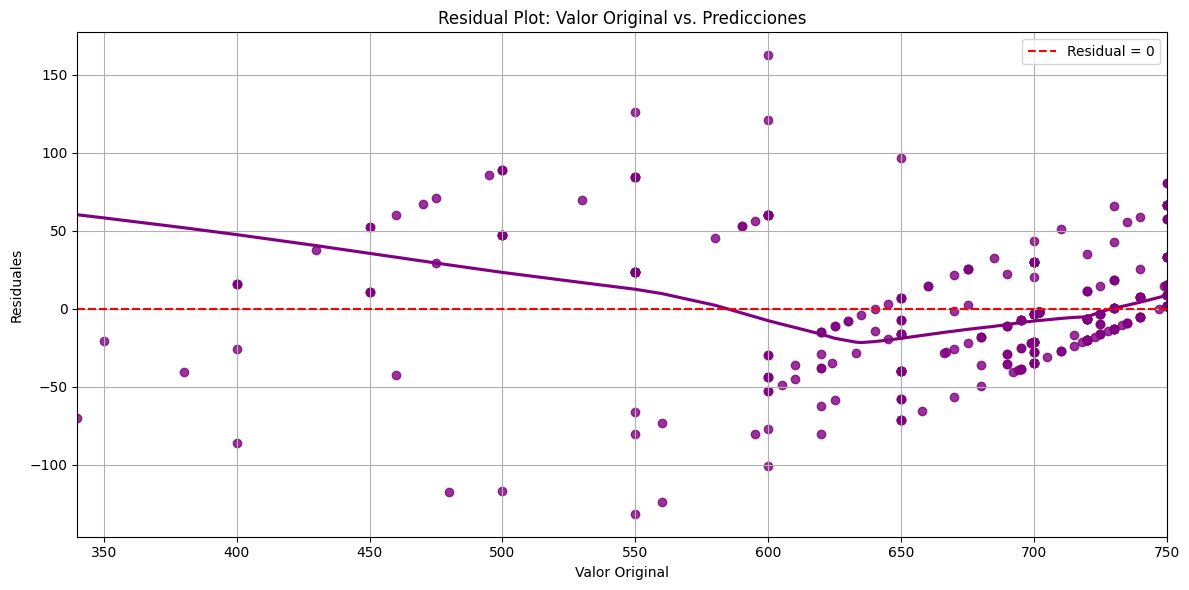

In [65]:
residual_plot(df_comparador,"price","price_pred")